**Table of contents**<a id='toc0_'></a>    
- 1. [**Tour**: CNNs, nonlinear regression, model tuning, & regression trees](#toc1_)    
- 2. [**Ex 1** *CNNs for image analysis*](#toc2_)    
  - 2.1. [**1.1** Image generation](#toc2_1_)    
  - 2.2. [**1.2** Label training/validation images](#toc2_2_)    
  - 2.3. [**1.3** Build CNN](#toc2_3_)    
  - 2.4. [**1.4** Fit CNN](#toc2_4_)    
  - 2.5. [**1.5** Visualize CNN kernel](#toc2_5_)    
  - 2.6. [**1.6** CNN model experimentation](#toc2_6_)    
- 3. [**Ex 2** *Non-linear regression*](#toc3_)    
- 4. [**Ex 3** *Model tuning*](#toc4_)    
  - 4.1. [**3.1** Plotting validation loss](#toc4_1_)    
  - 4.2. [**3.2** Logistic regression](#toc4_2_)    
  - 4.3. [**3.3** Adding hidden layers](#toc4_3_)    
- 5. [**Ex 4** *Regression trees & boosting*](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[**Tour**: CNNs, nonlinear regression, model tuning, & regression trees](#toc0_)

*Matthew Bain*
<hr/>

We start by importing all the Python libraries we will need for this project. We also define some global parameters.


In [ ]:
# dependencies and global variables
# essentials
import numpy.linalg as LA           # linalg module of numpy
import pandas as pd                 # pandas for data manipulation
import autograd.numpy as np         # autograd-wrapped numpy

# optimization
from autograd import grad           # module for computing gradient

# plotting
import matplotlib.pyplot as plt     # pyplot module of matplotlib

# path to datasets and output directories
datapath = '/Users/matthewbain/Documents/Math/courses/semester II/' + \
    'PHYS 3G03/3G0-assignments/HW 5/code/'

# global plotting parameters
plt_colours = (
    np.array([94,255,231])/360, np.array([133,94,214])/360,
    np.array([110,250,152])/360
    )
font_size   = 14
font_name   = {'fontname': 'Avenir'}

# to prevent warning messages from appearing in the report
import warnings;
warnings.filterwarnings('ignore')

# 2. <a id='toc2_'></a>[**Ex 1** *CNNs for image analysis*](#toc0_)

In this exercise we experiment with using a convolutional neural network for performaing basic image classification.

Below we define a function (provided to us) that randomly generates black images with randomly arranged (vertical or horizontal) stripes.


In [ ]:
# [def] generate image
### generate random (black) square image w/ `stripe_nr` (white) stripes
np.random.seed(19680801) # seed random number generator

def generate_stripe_image(size, stripe_nr, vertical = True):
    img = np.zeros((size, size, 1), dtype = "uint8") # init size^2 img of 0's
    for i in range(0, stripe_nr):
        x, y = np.random.randint(0, size, 2) # gen 2 rand int btwn 0 & size
        l = np.int(np.random.randint(y, size, 1)) # rand int btwn y & size
        if (vertical): # set to True by default
            img[y:l, x, 0] = 255 # add vertical line from y:l in rand col x
        else:
            img[x, y:l, 0] = 255 # horizontal line in row x
    return img

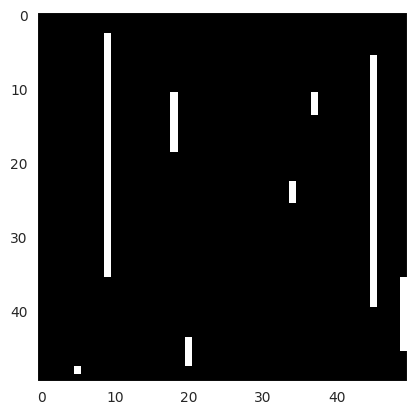

In [ ]:
# [fig] plot image
### plot example image for reference
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_style("dark")

img = generate_stripe_image(50, 10, vertical = True)
plt.imshow(img[:, :, 0], cmap = 'gray')

## 2.1. <a id='toc2_1_'></a>[**1.1** Image generation](#toc0_)

We start by using the function defined above to generate some training and validation images.

Parameters:
* `size` = 50
* `stripe_nr` = 10
* |`X_train`| = |`X_val`| = 1000
* `vertical` = True for 500 images in both training and test set


In [ ]:
### generate training and validation sets
## parameter settings
n_img = 1000
# n_stripes = 10
# img_size = 50

## initializations
# initialize empty arrays to store training/validation sets
X_train = X_val = np.empty([n_img, 50, 50, 1])

vert = True # initially generate vertical images
n_vert = .5*n_img

## generate images
for i in range(np.shape(X_train)[0]):
    # start generating horizontal images half-way through loop
    if i == n_vert - 1:
      vert = False

    # generate & store
    X_train[i, :, :, :] = generate_stripe_image(50, 10, vert)
    X_val[i, :, :, :] = generate_stripe_image(50, 10, vert)

## (standard) normalize training and validation sets (based on training data)
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0) + 1e-7 # to deal w/ potential sd's of 0
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std

## 2.2. <a id='toc2_2_'></a>[**1.2** Label training/validation images](#toc0_)

Below we store the true class labels for our training and validation images.


In [ ]:
### store true class labels (0 = vert. stripes; 1 = horiz.)
Y_train = np.zeros(500)
Y_train = Y_val = np.append(Y_train, np.ones(500))

In [ ]:
### one-hot encode labels (as this is the format required by tf/keras)
import tensorflow as tf
from tensorflow import keras

Y_train = tf.keras.utils.to_categorical(y = Y_train, num_classes = 2)
Y_val = tf.keras.utils.to_categorical(y = Y_val, num_classes = 2)

## 2.3. <a id='toc2_3_'></a>[**1.3** Build CNN](#toc0_)

We now build a convolutional neural network with 3 layers:

1. 5 x 5 single convolution kernel (*filter*) layer; linear activation
2. 2D max pooling layer with a pool size of 50
3. dense layer with 2 neurons; softmax activation


In [ ]:
### build 3-layer CNN
model = keras.models.Sequential([
    keras.layers.Conv2D(
        filters = 1,
        kernel_size = 5,
        activation = 'linear',
        padding = 'same',
        input_shape = [50, 50, 1]
        ),
    keras.layers.MaxPooling2D(pool_size = 50),
    keras.layers.Flatten(), # flatten because dense layer expects 1D array
    keras.layers.Dense(units = 2, activation = 'softmax')
    ])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-07-02 15:29:08.471067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-02 15:29:08.471593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
### compile model (provided code)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
    )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 1)         26        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 1)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 2)                 4         
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


Our model has 30 parameters in total:
* 26 from layer 1 (5 x 5 filter weights + bias)
* 0 from layer 2 (pooling layers do not have weights as they merely aggregate inputs)
* 4 from layer 3 (1 weight + bias per neuron)


## 2.4. <a id='toc2_4_'></a>[**1.4** Fit CNN](#toc0_)

We now fit our convolutional neural network model to the training data and validate on the test data.


In [ ]:
### fit CNN (provided code)
history = model.fit(
    X_train, Y_train,
    validation_data = (X_val, Y_val),
    batch_size = 64,
    epochs = 50,
    verbose = 0, # suppress printing reports for each epoch
    shuffle = True
    )

2023-07-02 15:29:08.826468: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-02 15:29:09.211148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:29:09.759828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Having built, compiled, and trained/validated (fit) our model, we now produce some plots to allow us to visualize its performance. Below we plot: (1) model and validation loss; (2) model and validation accuracy, both as a function of training epoch.


In [ ]:
### store data
import pandas as pd

# history.history.keys()
plot_data = dict(
    x_plt        = np.arange(50),
    y_model_loss = history.history['loss'],
    y_val_loss   = history.history['val_loss'],
    y_model_acc  = history.history['accuracy'],
    y_val_acc    = history.history['val_accuracy']
    )

# store plotting data in data frame
plot_data = pd.DataFrame.from_dict(plot_data)

In [ ]:
### [def] define plotting function
def plot_cost_and_accuracy(data):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import pandas as pd

    # store data
    x_plt           = data.iloc[:, 0]
    y_loss_model    = data.iloc[:, 1]
    y_loss_val      = data.iloc[:, 2]
    y_acc_model     = data.iloc[:, 3]
    y_acc_val       = data.iloc[:, 4]

    # use seaborn style
    sns.set_theme()

    # to prevent warning messages from appearing in the report
    import warnings;
    warnings.filterwarnings('ignore')

    # set inline figure format/quality, overall params
    %config InlineBackend.figure_format = 'svg'

    # setup plot & subplots
    fig, axs = plt.subplots(
        2, 1,
        figsize = np.array([6.5, 8]),
        constrained_layout = True # overall layout, size
        )
    # axs[0] = plt.subplot(1,3,(1,2), frameon = 1)
    axs[0] = plt.subplot(211, frameon = 1)
    axs[1] = plt.subplot(212, frameon = 1)

    # set axis tick sizes
    axs[0].xaxis.set_tick_params(labelsize = font_size - 4)
    axs[0].yaxis.set_tick_params(labelsize = font_size - 4)
    axs[1].xaxis.set_tick_params(labelsize = font_size - 4)
    axs[1].yaxis.set_tick_params(labelsize = font_size - 4)

    # plot overlay of (1) loss & (2) accuracy vs epoch
    line_loss_model = axs[0].plot(
        x_plt, y_loss_model,
        color = plt_colours[0],
        linestyle = '-', linewidth = 2
        )
    line_loss_val   = axs[0].plot(
        x_plt, y_loss_val,
        color = plt_colours[1],
        linestyle = '-', linewidth = 2
        )
    line_acc_model  = axs[1].plot(
        x_plt, y_acc_model,
        color = plt_colours[0],
        linestyle = '-', linewidth = 2
        )
    line_acc_val    = axs[1].plot(
        x_plt, y_acc_val,
        color = plt_colours[1],
        linestyle = '-',
        linewidth = 2
        )

    # add labels
    # axs[0].set_xlabel('iteration', fontsize = font_size, **font_name)
    axs[0].set_xlabel('epoch', fontsize = font_size)
    axs[0].set_ylabel('loss', fontsize = font_size)
    axs[1].set_xlabel('epoch', fontsize = font_size)
    axs[1].set_ylabel('accuracy', fontsize = font_size)

    # plot legend
    leg_labels = ['training', 'validation']
    axs[0].legend(
        [line_loss_model, line_loss_val],
        labels = leg_labels,
        # loc = 'upper right',
        loc = 'center left',
        bbox_to_anchor = (1, 0.5),
        frameon = 0,
        fontsize = font_size - 4
        )
    axs[1].legend(
        [line_acc_model, line_acc_val],
        labels = leg_labels,
        # loc = 'upper right',
        loc = 'center left',
        bbox_to_anchor = (1, 0.5),
        frameon = 0,
        fontsize = font_size - 4
        )

    plt.show()

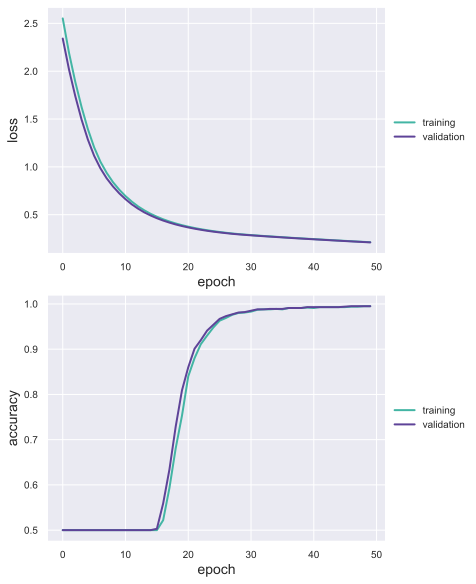

final training accuracy achieved: 0.995
final validation accuracy achieved: 0.995


In [ ]:
### [fig] plot
plot_cost_and_accuracy(plot_data)
print(
    "final training accuracy achieved: " +
    str(round(plot_data["y_model_acc"][49], 4))
    )
print(
    "final validation accuracy achieved: " +
    str(round(plot_data["y_val_acc"][49], 4))
    )

## 2.5. <a id='toc2_5_'></a>[**1.5** Visualize CNN kernel](#toc0_)

We will now check that our CNN is doing its job by looking at the kernel obtained through training, which should be something capable of distinguishing horizontal and vertical stripes.


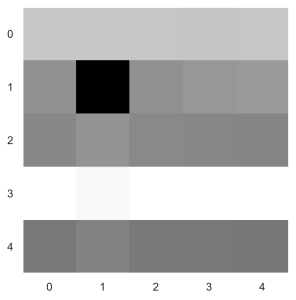

In [ ]:
### [fig] plot kernel
import seaborn as sns
sns.set_style("dark")

conv_filter = model.get_weights()[0]
plt.imshow(conv_filter[:, :, 0, 0], cmap = 'gray')

Based on the appearance of the kernel obtained by the CNN, the CNN appears to be doing its job. This kernel resembles a weight map that should be capable of distinguishing horizontal and vertical lines. The kernel has elements resembling vertical stripes (e.g., two black lines in columns 0 and 2), which, when convolved with an image, should enhance the vertical lines and attenuate everything else, leading to correct categorization of images with vertical stripes. Similarly, the kernel has elements resembling horizontal stripes (e.g., gray lines in rows 1, 3, and 5), which, when convolved with an image, should enhance the horizontal lines and attenuate everything else, leading to correct categorization of images with horizontal stripes.


## 2.6. <a id='toc2_6_'></a>[**1.6** CNN model experimentation](#toc0_)

We will now experiment a bit with our network. In each of the following three code blocks, we will fit the CNN again, with the following modifications:

1. use a ReLU (instead of linear) activation in layer 1
2. use average (instead of max) pooling in layer 2
3. use a different kernel size, e.g., 10


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 50, 50, 1)         26        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 1)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4         
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


2023-07-02 15:29:28.187839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:29:28.632031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


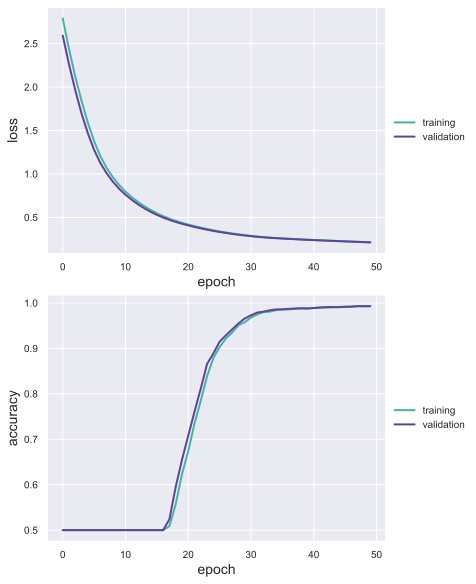

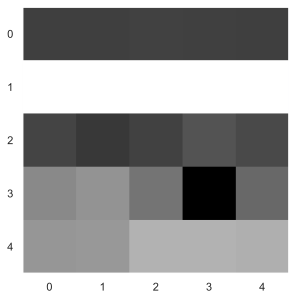

final training accuracy achieved: 0.993
final validation accuracy achieved: 0.993


In [ ]:
### [fig] modifcation 1
## fit network
# build CNN
model = keras.models.Sequential([
    keras.layers.Conv2D(
        filters = 1,
        kernel_size = 5,
        activation = 'relu',
        padding = 'same',
        input_shape = [50, 50, 1]
        ),
    keras.layers.MaxPooling2D(pool_size = 50),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 2, activation = 'softmax')
])

# compile model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
    )
model.summary()

# fit CNN
history = model.fit(
    X_train, Y_train,
    validation_data = (X_val, Y_val),
    batch_size = 64,
    epochs = 50,
    verbose = 0,
    shuffle = True
    )

## visualize network performance
# plot loss and accuracy histories
import pandas as pd
plot_data = dict(
    x_plt        = np.arange(50),
    y_model_loss = history.history['loss'],
    y_val_loss   = history.history['val_loss'],
    y_model_acc  = history.history['accuracy'],
    y_val_acc    = history.history['val_accuracy']
    )
plot_data = pd.DataFrame.from_dict(plot_data)
plot_cost_and_accuracy(plot_data)

# plot kernel
import seaborn as sns
sns.set_style("dark")
conv_filter = model.get_weights()[0]
plt.imshow(conv_filter[:, :, 0, 0], cmap = 'gray')
plt.show()

# output accuracies
print(
    "final training accuracy achieved: " +
    str(round(plot_data["y_model_acc"][49], 4))
    )
print(
    "final validation accuracy achieved: " +
    str(round(plot_data["y_val_acc"][49], 4))
    )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 50, 50, 1)         26        
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1)          0         
 ooling2D)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 1)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 4         
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


2023-07-02 15:29:47.745662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:29:48.143682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


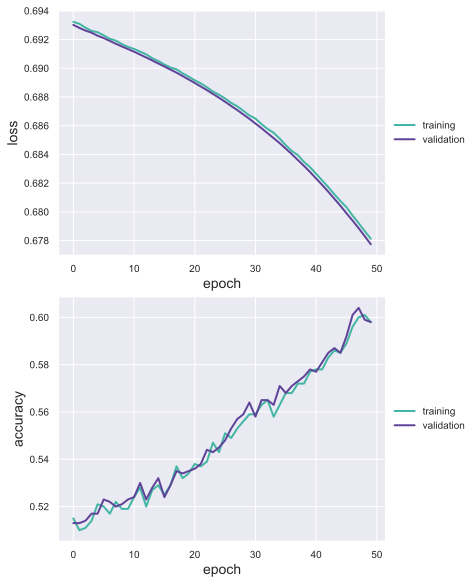

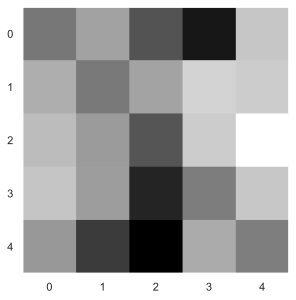

final training accuracy achieved: 0.598
final validation accuracy achieved: 0.598


In [ ]:
### [fig] modifcation 2
## fit network
# build CNN
model = keras.models.Sequential([
    keras.layers.Conv2D(
        filters = 1,
        kernel_size = 5,
        activation = 'linear',
        padding = 'same',
        input_shape = [50, 50, 1]
        ),
    keras.layers.AveragePooling2D(pool_size = 50),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 2, activation = 'softmax')
    ])

# compile model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
    )
model.summary()

# fit CNN
history = model.fit(
    X_train, Y_train,
    validation_data = (X_val, Y_val),
    batch_size = 64,
    epochs = 50,
    verbose = 0, # suppress printing reports for each epoch
    shuffle = True
    )

## visualize network performance
# plot loss and accuracy histories
import pandas as pd
plot_data = dict(
    x_plt        = np.arange(50),
    y_model_loss = history.history['loss'],
    y_val_loss   = history.history['val_loss'],
    y_model_acc  = history.history['accuracy'],
    y_val_acc    = history.history['val_accuracy']
    )
plot_data = pd.DataFrame.from_dict(plot_data)
plot_cost_and_accuracy(plot_data)

# plot kernel
import seaborn as sns
sns.set_style("dark")
conv_filter = model.get_weights()[0]
plt.imshow(conv_filter[:, :, 0, 0], cmap = 'gray')
plt.show()

# output accuracies
print(
    "final training accuracy achieved: " +
    str(round(plot_data["y_model_acc"][49], 4))
    )
print(
    "final validation accuracy achieved: " +
    str(round(plot_data["y_val_acc"][49], 4))
    )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 50, 50, 1)         101       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 1)          0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 4         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


2023-07-02 15:30:04.835263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:30:05.314583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


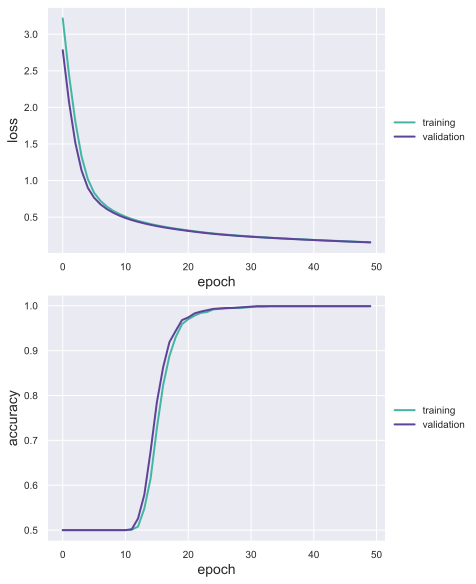

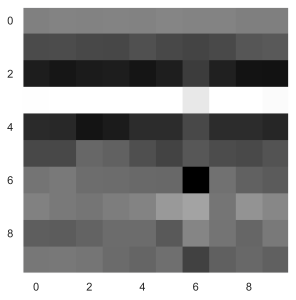

final training accuracy achieved: 0.999
final validation accuracy achieved: 0.999


In [ ]:
### [fig] modifcation 3
## fit network
# build CNN
model = keras.models.Sequential([
    keras.layers.Conv2D(
        filters = 1,
        kernel_size = 10,
        activation = 'linear',
        padding = 'same',
        input_shape = [50, 50, 1]
        ),
    keras.layers.MaxPooling2D(pool_size = 50),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 2, activation = 'softmax')
    ])

# compile model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])
model.summary()

# fit CNN
history = model.fit(
    X_train, Y_train,
    validation_data = (X_val, Y_val),
    batch_size = 64,
    epochs = 50,
    verbose = 0, # suppress printing reports for each epoch
    shuffle = True
    )

## visualize network performance
# plot loss and accuracy histories
import pandas as pd
plot_data = dict(
    x_plt        = np.arange(50),
    y_model_loss = history.history['loss'],
    y_val_loss   = history.history['val_loss'],
    y_model_acc  = history.history['accuracy'],
    y_val_acc    = history.history['val_accuracy']
    )
plot_data = pd.DataFrame.from_dict(plot_data)
plot_cost_and_accuracy(plot_data)

# plot kernel
import seaborn as sns
sns.set_style("dark")
conv_filter = model.get_weights()[0]
plt.imshow(conv_filter[:, :, 0, 0], cmap = 'gray')
plt.show()

# output accuracies
print(
    "final training accuracy achieved: " +
    str(round(plot_data["y_model_acc"][49], 4))
    )
print(
    "final validation accuracy achieved: " +
    str(round(plot_data["y_val_acc"][49], 4))
    )

Based on the visualizations (loss/accuracy histories and kernels) produced for each of the above cases, we make the following observations on how these modifications affect model performance:

1. This network (ReLU, as opposed to linear, activation) achieves very good performance, comparable to our original (linear activation) network. The obtained kernel appears capable of distinguishing horizontal from vertical stripes, for similar reasons to those provided for the original network. This network appears to achieve high accuracy slightly faster than the original network. The ReLU activation function typically performs better than linear activation, and is the "most popular activation function in use today"[^1].

2. This network (average, as opposed to max, pooling) does appear to be 'learning in the right direction' (based on the positive trajectory of its accuracy history) but after 50 training epochs does not perform much better than chance. This could have to do with these black-and-white images not being represented well by average pixel values (i.e., between 0 = black and 255 = white), and therefore performing better with a pooling layer that aggregates inputs by taking their maximum.

3. This network (kernel size of 10, as opposed to 5) achieves near-perfect accuracy (reflected in the kernel image, which has finer details than those in previous cases, likely increasing network resolution), but at a significant computational cost. This increased computational cost is due to the 105 parameters, up from 30 in previous cases. Further increases in kernel size may also lead to overfitting, such that network performance on unseen data begins to decline.

[^1]: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.


# 3. <a id='toc3_'></a>[**Ex 2** *Non-linear regression*](#toc0_)

In this exercise, based on Example 10.3 in *Machine Learning Refined* [^1], we will fit a non-linear regression model to a dataset containing multiple sine waves. We will use the following parameterized sinusoidal feature transformations:

$$
f_1(\vec{x}) = sin(w_{1, 0} + w_{1, 1} x_1 + w_{1, 2} x_2)
$$
$$
f_2(\vec{x}) = sin(w_{2, 0} + w_{2, 1} x_1 + w_{2, 2} x_2)
$$

These features then serve as input to our model, which returns a linear combination of $f_1$ and $f_2$, given by

$$
model(x, \Theta) = w_0 + f_1(x) w_1 + f_2(x) w_2 \space ,
$$

where $\Theta$ is a set of weights containing both the feature transformation weights and the final linear combination weights.

The code below is provided in *Machine Learning Refined* [^1].

[^1]: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.


In [ ]:
### [def*2] define model and feature transformations
import autograd.numpy as np

def feature_transforms(x, w):
    a = w[0] + np.dot(x.T, w[1:])
    return np.sin(a).T

def model(x, w):
    # feature transformation
    f = feature_transforms(x, w[0])

    # compute linear combination and return
    a = w[1][0] + np.dot(f.T, w[1][1:])
    return a.T

*note: The function `feature_transforms` takes a single matrix of feature transformation weights, with the weights for each feature arranged in a vertical vector. The function then returns feature-transformed inputs, `f` , with the outputs for each feature arranged in a vertical vector. In the function `model` , `w[1][0]` returns row 1 of entry 1 of `w` , which should contain the intercept for each fit (which is a linear combination of each feature).*

Below we import the dataset.


In [ ]:
### import dataset (code provided by course instructor)
import numpy as np

datapath = ''

csvname = datapath + 'multiple_sine_waves.csv'
data = np.loadtxt(csvname, delimiter = ',')
x = data[:2, :] # notice: we are dealing with 2-d input (x1, x2)
y = data[2:, :] # notice: we are dealing with 2 sinusoidal (1D) outputs

Based on this input and output ($x, y$), we make the following important observations on the dimensionality of our dataset:

We are dealing with a two-dimensional input space $(x_1, x_2)$, on which we define two parametrized feature transformations $(f_1, f_2)$, parametrized in terms of $w_{1, 0}, ..., w_{2, 2}$. We can store these feature weights in a matrix, $\Theta_0$, with the following structure:

$$
\begin{bmatrix}
w_{1, 0} & 2 & 1 \\
3 & 0 & 1 \\
0 & 2 & 4
\end{bmatrix}
$$

Our ouput is also two-dimensional, meaning that we must fit two separate models to our dataset. For our purposes, we will assume that each model relies on the same feature transformation weights (such that we need only optimize one feature transformation weight matrix, $\Theta_0$).

Below we define (as in earlier homework assignments) the standard gradient descent function, which we will use to optimize this model.


In [ ]:
### [def] GD function (provided in Machine Learning Refined)
import autograd.numpy as np
from autograd import value_and_grad
from autograd.misc.flatten import flatten_func

def gradient_descent(g, alpha, max_its, w):
    # flatten cost function, w to deal w/ costs that have layers of parameters
    g_flat, unflatten, w = flatten_func(g, w) # flatten all rows into squence

    # compute gradient
    gradient = value_and_grad(g_flat)

    # run GD loop
    weight_history = [] # weight history container
    cost_history = []   # cost history container
    for k in range(1, max_its + 1):

        # evaluate the gradient & store current (unflattened) weights and cost
        cost_eval, grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval

    # collect final weights & # compute final cost
    weight_history.append(unflatten(w))
    cost_history.append(g_flat(w))

    return weight_history, cost_history

Below we define our (least squares) cost function.


In [ ]:
### [def] least squares cost
def least_squares(w):
    cost = np.sum((model(x, w) - y)**2)
    return cost/float(np.size(y))

Below we select our gradient descent parameters and then fit our model by minimizing a least squares cost function over the dataset.


In [ ]:
### optimize least squares cost function
import autograd.numpy as np

# randomly generate initial weights
n_features = 2
scale = 1
w = [
     scale*np.random.randn(n_features + 1, n_features),
     scale*np.random.randn(n_features + 1, n_features)
     ]

# run GD
weight_history, cost_history = gradient_descent(
     g = least_squares,
     alpha = 10**(0),
     max_its = 2000,
     w = w
     )

Below we plot the cost history for our fitted model.


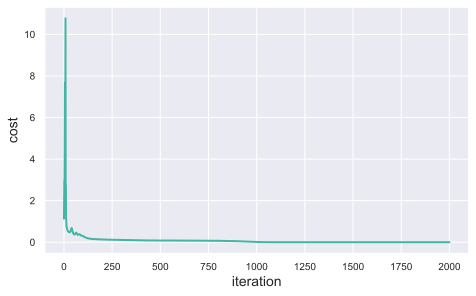

In [ ]:
# [fig] plot cost history
### plot cost history
x_plt  = range(2000 + 1)
y_cost = cost_history

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# use seaborn style
sns.set_theme()

# to prevent warning messages from appearing in the report
import warnings;
warnings.filterwarnings('ignore')

# set inline figure format/quality, overall params
%config InlineBackend.figure_format = 'svg'

# setup plot & subplots
fig, axs = plt.subplots(
    1, 1,
    figsize = np.array([6.5, 4]),
    constrained_layout = True) # overall layout, size
axs = plt.subplot(111, frameon = 1)

# set axis tick sizes
axs.xaxis.set_tick_params(labelsize = font_size - 4)
axs.yaxis.set_tick_params(labelsize = font_size - 4)

# plot cost history
line_cost = axs.plot(
    x_plt, y_cost,
    color = plt_colours[0],
    linestyle = '-', linewidth = 2)

# add labels
axs.set_xlabel('iteration', fontsize = font_size)
axs.set_ylabel('cost', fontsize = font_size)

plt.show()

Below we display the optimal parameters (i.e., those that minimize cost).


In [ ]:
### display optimal parameters
weight_history[np.argmin(cost_history)]

[array([[-3.14159255, -3.1415917 ],
        [ 5.75457452,  3.65414775],
        [ 5.25143893,  8.17371846]]),
 array([[ 2.63083226e-07,  1.25466281e-07],
        [ 4.26450041e-06,  9.99999562e-01],
        [-1.00000242e+00,  8.91871310e-07]])]

The optimal feature transformation parameters determine the following transformations:

$$
f_1(\vec{x}) = sin(3.14 -3.65 x_1 -8.17 x_2)
$$
$$
f_2(\vec{x}) = sin(3.14 -5.75 x_1 -5.25 x_2)
$$


# 4. <a id='toc4_'></a>[**Ex 3** *Model tuning*](#toc0_)

In this exercise we revisit the MNIST dataset and experiment with finding the optimal model tuning.

We will use the classifier defined below (*provided by course instructor*).


In [ ]:
### initial classifier
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

model = keras.Sequential(
    [layers.Dense(512, activation = 'relu'),
     layers.Dense(10, activation = 'softmax')]
    )

alpha = 1.
model.compile(
    optimizer = keras.optimizers.RMSprop(alpha),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

history = model.fit(
    train_images, train_labels,
    epochs = 10,
    batch_size = 128,
    validation_split = 0.2,
    verbose = 0
    )

2023-07-02 15:30:27.684988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:30:30.180755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## 4.1. <a id='toc4_1_'></a>[**3.1** Plotting validation loss](#toc0_)

Below we plot validation loss as a function of epoch for several different training rates, $\alpha$:

1. 1
2. 0.5
3. 0.1
4. 0.01
5. 0.001

*note: accuracy is, in this case, defined as the percentage of correct predictions.*


In [ ]:
### [def] define function for plotting validation loss history
# store loss as list of arrays, alpha values as list (lists should be equal len)
def plot_loss_hist(epochs, loss, alpha):
    ## dependencies and initializations
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import pandas as pd

    # use seaborn style
    sns.set_theme()
    plt_colours = sns.color_palette("husl", 9)

    # to prevent warning messages from appearing in the report
    import warnings;
    warnings.filterwarnings('ignore')

    # inline fig format/quality
    %config InlineBackend.figure_format = 'svg'

    ## plot setup
    # define plotting data
    x_plt = range(epochs)

    # setup plot
    fig, axs = plt.subplots(
        1, 1,
        figsize = np.array([6.5, 4]),
        constrained_layout = True
        )
    axs = plt.subplot(111, frameon = 1)

    ## aesthetics
    # set axis tick sizes
    axs.xaxis.set_tick_params(labelsize = font_size - 4)
    axs.yaxis.set_tick_params(labelsize = font_size - 4)

    # axis tick labels
    # axs.set_xticks(list(np.arange(0, epochs, 1)))
    # axs.set_xticklabels(list(np.arange(1, epochs + 1, 1)))
    axs.set_xlim([min(x_plt) - .5, max(x_plt) + .5])
    # axs.set_ylim(ymin = 0, ymax = 30)

    axs.plot(box = 0)

    ## plot
    # plot loss history
    line_loss = []
    for i in range(len(loss)):
        line_loss_current = axs.plot(
            x_plt, np.squeeze(loss[i]),
            color = plt_colours[i],
            linestyle = '-',
            linewidth = 2
            )
        line_loss.append(line_loss_current)

    ## labels
    # add labels
    axs.set_xlabel('epoch', fontsize = font_size)
    axs.set_ylabel('loss', fontsize = font_size)

    # plot legend
    # plt.rcParams['text.usetex'] = True
    labels = []
    for i in range(len(loss)):
        # labels.append(r'$\alpha = $' + ' ' + str(alpha[i]))
        labels.append('alpha = ' + str(alpha[i]))
    axs.legend(
        line_loss, labels = labels,
        frameon = 1, loc = 'upper right'
        )

    plt.show()

In [ ]:
### fit model for several learning rates
# define learning rates
alpha = [1., 0.5, 0.1, 0.01, 0.001]
n_epochs = 10

# loop through all alpha values & build/compile network
loss = []
for i in range(len(alpha)):
    model.compile(
        optimizer = keras.optimizers.RMSprop(alpha[i]),
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
        )

    history = model.fit(
        train_images, train_labels,
        epochs = n_epochs,
        batch_size = 128,
        validation_split = 0.2,
        verbose = 0)

    loss.append([history.history['val_loss']])

2023-07-02 15:30:53.544848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:30:55.763892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:31:18.412529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:31:21.267101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:31:47.238612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:31:49.868525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:32:12.945997: I tensorflow/core/grappler/optimizers/cust

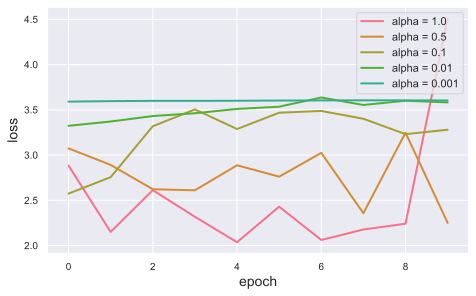

In [ ]:
### [fig] plot validation loss history for all alpha values
plot_loss_hist(n_epochs, loss, alpha)

From the plot of validation loss history above, we see that decreasing the value of $\alpha$ appears to reduce the initial validation loss of the network, but provides little benefit over successive training epochs, in fact resulting in overall loss increases. The initial training rate $\alpha$ = 1.0 results in the best performance after the first epoch. This suggests that of the $\alpha$ values attempted here, the RMSprop optimizer performs best for this network with a training rate of 1. The high loss on epoch 1 could be due to the optimizer taking an initial step in the direction of a local maximum.


## 4.2. <a id='toc4_2_'></a>[**3.2** Logistic regression](#toc0_)

The model below (*provided by the course instructor*) performs logistic regression on the MNIST data.


In [ ]:
### fit one-layer dense network model
model = keras.Sequential(
    [layers.Dense(10, activation = 'softmax')]
    )

model.compile(
    optimizer = 'rmsprop',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

history_small_model = model.fit(
    train_images, train_labels,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.2,
    verbose = 0
    )
model.summary()

2023-07-02 15:33:06.385320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:33:08.233428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Below we again look at validation loss as a function of epoch.

*note: without specifying learning rate, the RMSprop optimizer defaults to a learning rate of 0.001.*


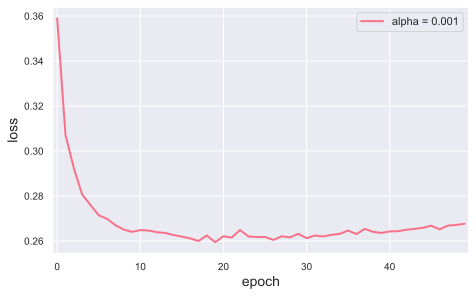

In [ ]:
### [fig] plot validation loss history
plot_loss_hist(
    epochs = 50,
    loss = [history_small_model.history['val_loss']],
    alpha = [0.001]
    )

Observing the validation loss history, above, for our small network model, there appears to be a clear minimum, around 20 epochs, beyond which loss begins to increase, indicating overfitting.


## 4.3. <a id='toc4_3_'></a>[**3.3** Adding hidden layers](#toc0_)

The code below (*again provided by the course instructor*) increases the complexity of our model by adding hidden layers. We will plot validation loss history once again to visualize the effect of this modification on model performance.


In [ ]:
### increase model complexity by adding hidden layers
model = keras.Sequential(
    [layers.Dense(96, activation = 'relu'),
     layers.Dense(96, activation = 'relu'),
     layers.Dense(10, activation = 'softmax')]
    )

model.compile(
    optimizer = 'rmsprop',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

history_large_model = model.fit(
    train_images, train_labels,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.2,
    verbose = 0
    )

model.summary()

2023-07-02 15:34:48.369380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-02 15:34:51.275148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 96)                75360     
                                                                 
 dense_8 (Dense)             (None, 96)                9312      
                                                                 
 dense_9 (Dense)             (None, 10)                970       
                                                                 
Total params: 85,642
Trainable params: 85,642
Non-trainable params: 0
_________________________________________________________________


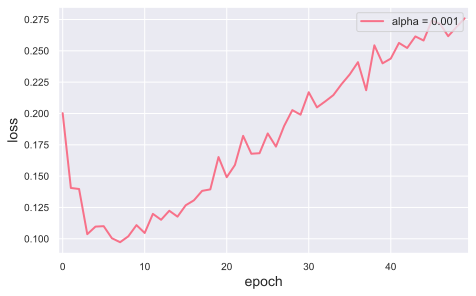

In [ ]:
### [fig] plot validation loss history
plot_loss_hist(
    epochs = 50,
    loss = [history_large_model.history['val_loss']],
    alpha = [0.001]
    )

Observing the validation loss history for our large network model, above, we see that beyond ~10 training epochs there appears to be significant overfitting. Between epochs ~10 and 50, validation loss begins to steadily increase, indicating declining model performance. This makes sense given the numerous parameters in this model, totalling 85, 642.


# 5. <a id='toc5_'></a>[**Ex 4** *Regression trees & boosting*](#toc0_)

In this exercise we build a basic regression tree model from scratch and use it to model some manually generated noisy sinusoidal data. We then compare its output to that of Scikit-learn's built in tree regressor. In order to simplify the task of programming our model from scratch, we make the following assumptions:

* our dataset is one-dimensional
* we only need to know the result of the regression for the points $x_p$

The code below (*provide by course instructor*) uses Scikit-learn's built in tree regressor to fit two models, the first with a maximum depth of 2 and the second a maximum depth of 5.


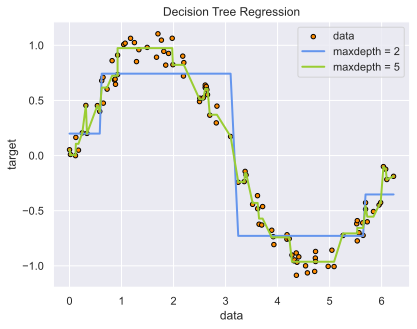

In [ ]:
## [fig] fit regression tree
# import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# create a random dataset
rng = np.random.RandomState(1)
X = np.sort(6.3 * rng.rand(100, 1), axis = 0)
y = np.sin(X).ravel()
y += 0.3 * (0.5 - rng.rand(len(X)))

# fit regression model
regr_1 = DecisionTreeRegressor(max_depth = 2)
regr_2 = DecisionTreeRegressor(max_depth = 5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# plot results
plt.figure()
plt.scatter(
    X, y, label = "data",
    s = 20, c = "darkorange", edgecolor = "black"
    )
plt.plot(
    X, y_1, label = "maxdepth = 2",
    color = "cornflowerblue", linewidth = 2
    )
plt.plot(
    X, y_2, label = "maxdepth = 5",
    color = "yellowgreen", linewidth = 2
    )
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Below we implement our own decision tree regressor, which performs regression to a set maximum depth. We will use a least squares cost to optimize split points, which will lie between two values $x_p$. We will determine leaf values as the average of the $y_p$ values on either side of each split.


In [ ]:
### [def] define tree regressor from scratch
def My_TreeRegressor(y, il, ir, max_depth, level = 0):
    global yreg

    if (level == 0): yreg = np.zeros(len(y))

Below we fit our model to the noisy sinusoidal data and plot the results for comparison against those produced by Scikit-learn's tree regressor.


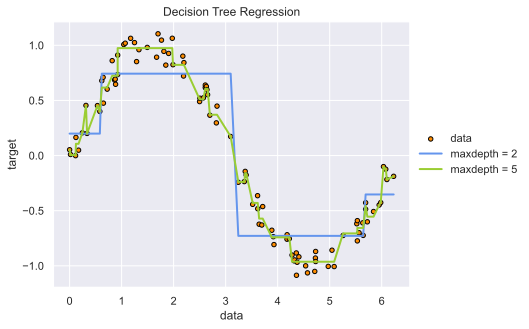

In [ ]:
### [fig] fit and plot
# fit regression model
regr_1 = DecisionTreeRegressor(max_depth = 2)
regr_2 = DecisionTreeRegressor(max_depth = 5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# plot results
plt.figure()
plt.scatter(
    X, y, label = "data",
    s = 20, c = "darkorange", edgecolor = "black"
    )
plt.plot(
    X, y_1, label = "maxdepth = 2",
    color = "cornflowerblue", linewidth = 2
    )
plt.plot(
    X, y_2, label = "maxdepth = 5",
    color = "yellowgreen", linewidth = 2
    )
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend(
    frameon = 0,
    loc = 'center left',
    bbox_to_anchor = (1, 0.5)
    )
plt.show()